## 6.1 이미지 분류를 위한 신경망
### 6.1.1 LeNet-5 


In [1]:
pip install --user tqdm

Note: you may need to restart the kernel to use updated packages.


In [29]:
#필요한 라이브러리 호출 
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F

import time
import os
import cv2
from PIL import Image
from tqdm import tqdm_notebook as tqdm
import random
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 


In [30]:
#이미지 데이터 셋 전처리 
class ImageTransform():
    def __init__(self,resize,mean,std):
        self.data_transform = {
            'train':transforms.Compose([
                transforms.RandomResizedCrop(resize,scale =(0.5,1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean,std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean,std)
            ])
        }
        
    def __call__(self,img,phase): #클래스를 호출할 수 있도록 하는 메서드, 클래스에 __call__ 메서드가 있으면 클래스 호출 시 call의 리턴값 리턴
        return self.data_transform[phase](img)
    

In [31]:
#이미지 데이터셋을 불러온 후 훈련 검증 테스트로 분리
cat_dir = r"C:/Users/CoIn241/Desktop/chan/torchbook_data/chap06/data/dogs-vs-cats/Cat"
dog_dir = r"C:/Users/CoIn241/Desktop/chan/torchbook_data/chap06/data/dogs-vs-cats/Dog"

cat_images_filepaths = sorted([os.path.join(cat_dir,f) for f in os.listdir(cat_dir)]) #cat_dir안에 이미지들을 모두 경로로 
dog_images_filepaths = sorted([os.path.join(dog_dir,f) for f in os.listdir(dog_dir)]) 

images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

random.seed(42)
random.shuffle(correct_images_filepaths)

train_images_filepaths = correct_images_filepaths[:400]

val_images_filepaths = correct_images_filepaths[400:-10]

test_images_filepaths = correct_images_filepaths[-10:]

print("num of train images : {}, num of validation image : {}, num of test iamges : {}".format(len(train_images_filepaths),len(val_images_filepaths), len(test_images_filepaths)))

num of train images : 400, num of validation image : 92, num of test iamges : 10


In [32]:
#테스트 데이터 셋 이미지 확인 함수 작성 
def display_image_grid(images_filepaths, predicted_labels=(), cols =5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows = rows, ncols = cols, figsize = (12,6))
    
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2] #이미지 전체 경로를 정규화하고 분할하는 코드 
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label,color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

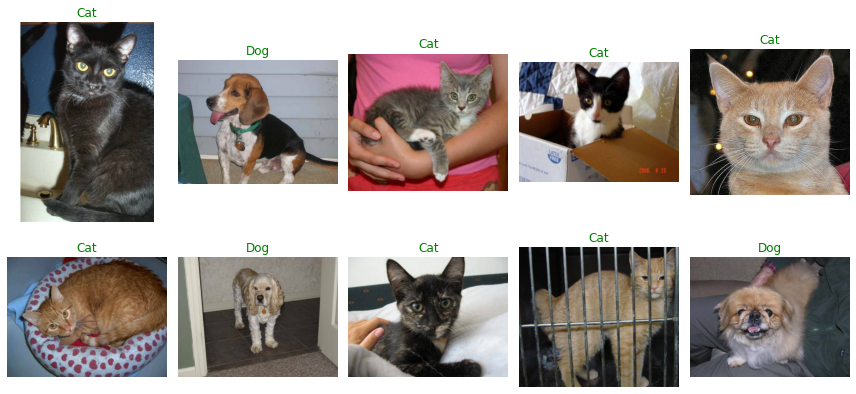

In [33]:
display_image_grid(test_images_filepaths)

In [34]:
# 이미지 데이터 셋 클래스 정의 
class DogvsCatDataset(Dataset):
    def __init__(self,file_list,transform=None,phase = 'train'):
        self.file_list = file_list
        self.transforms = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transforms(img,self.phase)
        label = img_path.split('\\')[-1].split('.')[0] #file 명에서 dog 인지 cat 인지 추출하는 것 
        if label == 'dog':
            label = 1 
        elif label == 'cat':
            label = 0
        return img_transformed, label 

In [35]:
#변수 값 정의
size = 224
mean = (0.485, 0.456, 0.406) # image net dataset의 평균
std = (.229, .224, .225)
batch_size = 32 

In [36]:
#이미지 데이터 셋 정의 
train_dataset = DogvsCatDataset(train_images_filepaths, transform=ImageTransform(size,
                                                                                mean,std),phase = 'train')
val_dataset = DogvsCatDataset(val_images_filepaths,transform = ImageTransform(size,
                                                                             mean,std),phase='val')

index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 224, 224])
0


In [37]:
#데이터로더 정의
train_dataloader = DataLoader(train_dataset,batch_size=batch_size,shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size,shuffle = False)
dataloader_dict = {'train':train_dataloader, 'val':val_dataloader}

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator) 
print(inputs.size())
print(label)

torch.Size([32, 3, 224, 224])
tensor([1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 0, 1])


In [38]:
#모델의 네트워크 클래스
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet,self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=3,out_channels=16,kernel_size = 5,stride = 1,padding = 0)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2)
        self.cnn2 = nn.Conv2d(in_channels = 16, out_channels= 32, kernel_size=5,stride=1,padding=0)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2)
        
        self.fc1 = nn.Linear(32*53*53,512)
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(512,2)
        self.output = nn.Softmax(dim=1)
        
    def forward(self,x):
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        
        out = out.view(out.size(0),-1)
        out = self.fc1(out)
        out = self.relu5(out)
        out = self.fc2(out)
        out = self.output(out)
        return out

In [39]:
#모델 객체 생성
model = LeNet()
model.to(device)
print(model)

LeNet(
  (cnn1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=89888, out_features=512, bias=True)
  (relu5): ReLU()
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (output): Softmax(dim=1)
)


In [40]:
from torchsummary import summary

In [41]:
summary(model, input_size = (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 220, 220]           1,216
              ReLU-2         [-1, 16, 220, 220]               0
         MaxPool2d-3         [-1, 16, 110, 110]               0
            Conv2d-4         [-1, 32, 106, 106]          12,832
              ReLU-5         [-1, 32, 106, 106]               0
         MaxPool2d-6           [-1, 32, 53, 53]               0
            Linear-7                  [-1, 512]      46,023,168
              ReLU-8                  [-1, 512]               0
            Linear-9                    [-1, 2]           1,026
          Softmax-10                    [-1, 2]               0
Total params: 46,038,242
Trainable params: 46,038,242
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 19.47
Params size (MB): 175.62
Es

In [42]:
#학습 가능한 파라미터 수 확인
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 46,038,242 trainable parameters


In [43]:
#옵티마이저와 손실 함수 정의
optimizer = optim.SGD(model.parameters(), lr = 0.01,momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [44]:
#모델의 파라미터와 손실 함수를 디바이스에 할당
model = model.to(device)
criterion = criterion.to(device)

In [57]:
def train_model(model,dataloader_dict, criterion, optimizer, num_epoch):
    since = time.time()
    best_acc = 0.0
    
    for epoch in range(num_epoch):
        print("Epoch {}/{}".format(epoch+1,num_epoch))
        print("-"*20)
        
        for phase in ['train','val']:
            if phase =='train':
                model.train()
            else:
                model.eval()
                
            epoch_loss = 0.0
            epoch_corrects = 0
            
            for inputs, labels in tqdm.notebook.tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad() #역전파를 실행하기 전에 기울기 0으로 초기화 
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _,preds = torch.max(outputs,1)
                    loss = criterion(outputs,labels) #손실함수로 오차 계산 
                    
                    if phase =='train':
                        loss.backward()
                        optimizer.step()
                        
                    epoch_loss += loss.item()*inputs.size(0)#reduction ='mean'이기 때문에 오차를 구하고 그 값의 평균을 반환하기 때문에 배치 크기만큼 곱해줌
                    epoch_corrects += torch.sum(preds == labels.data)#정답과 예측이 같은 만큼 acc에 더해줌
                    
            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)
            
            print('{} LOSS: {:.4f} ACC: {:.4f}'.format(phase,epoch_loss,epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc: #검증 데이터셋에 대해 가장 최적의 정확도를 저장
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Best val ACC {:.4f}".format(best_acc))

    return model

In [58]:
#model 학습 
num_epoch = 10
model = train_model(model,dataloader_dict,criterion,optimizer,num_epoch)

Epoch 1/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train LOSS: 0.6679 ACC: 0.6050


  0%|          | 0/3 [00:00<?, ?it/s]

val LOSS: 0.6730 ACC: 0.5870
Epoch 2/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train LOSS: 0.6565 ACC: 0.6100


  0%|          | 0/3 [00:00<?, ?it/s]

val LOSS: 0.7514 ACC: 0.4891
Epoch 3/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train LOSS: 0.6718 ACC: 0.5900


  0%|          | 0/3 [00:00<?, ?it/s]

val LOSS: 0.6833 ACC: 0.5870
Epoch 4/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train LOSS: 0.6281 ACC: 0.6725


  0%|          | 0/3 [00:00<?, ?it/s]

val LOSS: 0.6929 ACC: 0.5652
Epoch 5/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train LOSS: 0.6193 ACC: 0.6850


  0%|          | 0/3 [00:00<?, ?it/s]

val LOSS: 0.6648 ACC: 0.6304
Epoch 6/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train LOSS: 0.6069 ACC: 0.6750


  0%|          | 0/3 [00:00<?, ?it/s]

val LOSS: 0.7189 ACC: 0.5761
Epoch 7/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train LOSS: 0.6281 ACC: 0.6775


  0%|          | 0/3 [00:00<?, ?it/s]

val LOSS: 0.6583 ACC: 0.6196
Epoch 8/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train LOSS: 0.6285 ACC: 0.6625


  0%|          | 0/3 [00:00<?, ?it/s]

val LOSS: 0.6871 ACC: 0.5870
Epoch 9/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train LOSS: 0.5992 ACC: 0.7025


  0%|          | 0/3 [00:00<?, ?it/s]

val LOSS: 0.6424 ACC: 0.6522
Epoch 10/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train LOSS: 0.6167 ACC: 0.6625


  0%|          | 0/3 [00:00<?, ?it/s]

val LOSS: 0.6494 ACC: 0.6196
Training complete in 0m 19s
Best val ACC 0.6522


In [62]:
#모델 테스트를 위한 함수 정의 
import pandas as pd

id_list = []
pred_list = []
_id = 0

with torch.no_grad():
    for test_path in test_images_filepaths:
        img = Image.open(test_path)
        _id = test_path.split('\\')[-1].split('.')[1]
        transform = ImageTransform(size,mean,std)
        img = transform(img,phase='val')
        img = img.unsqueeze(0)
        img = img.to(device)
        
        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs,dim=1)[:,1].tolist()
        id_list.append(_id)
        pred_list.append(preds[0])
        
res = pd.DataFrame({
    'id':id_list,
    'label':pred_list
})
res.sort_values(by='id',inplace=True)
res.reset_index(drop=True,inplace=True)

res.to_csv('./LeNet',index=False)

In [63]:
res.head(10) #label > 0.5 개 , 아니면 고양이

,id,label
0,109,0.362708
1,145,0.469776
2,15,0.717657
3,162,0.352729
4,167,0.715052
5,200,0.678224
6,210,0.561284
7,211,0.711982
8,213,0.311745
9,224,0.729230


In [64]:
class_ = classes = {0:'cat', 1:'dog'}
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        a = random.choice(res['id'].values)    
        label = res.loc[res['id'] == a, 'label'].values[0]
        if label > 0.5:
            label = 1
        else:
            label = 0
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

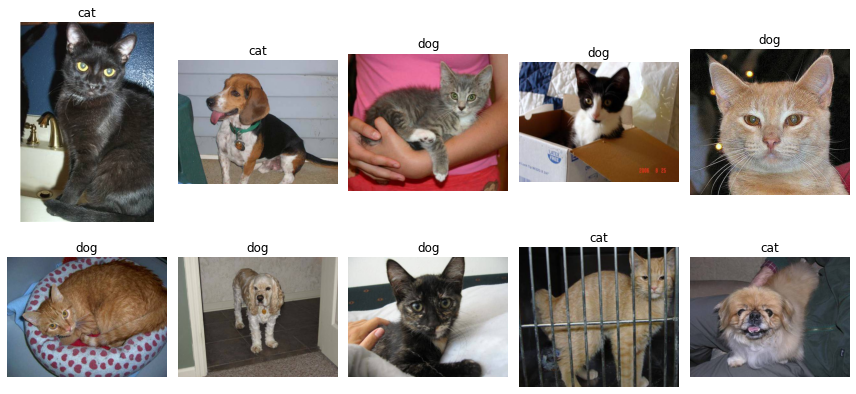

In [65]:
display_image_grid(test_images_filepaths) 